## Ensemble Model Notebook

---

### Objective:

- Given the chosen sampling rate, extraction interval and selected filtered features, to investigate the potential benefit of an ensemble model.

### Methodology:

- balance the classes for each model

- Create 3 distinct models:
  - 1 to classify artifacts (label 0) or not (label 1)
  - 1 to classify normal (label 0) or not (label 1)
  - 1 to classify murmur (label 0), extrastoles (label 1), extrahls (label 2)
- Create a 3rd fusion model to give the final class

#### Findings:

Selected Features after the correlation analysis:

#### Notes

| Name        | Label |
| ----------- | ----- |
| artifacts   | 0     |
| extrahls    | 1     |
| murmurs     | 2     |
| normals     | 3     |
| extrastoles | 4     |


In [1]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, accuracy_score,balanced_accuracy_score
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
from utils import rebalance_data

plt.style.use("seaborn-v0_8-paper")
import seaborn as sns
sns.set_theme(context="paper", font_scale=1)

In [2]:
# set the paths
BASE_DIR = "../../dataset/"

# features
FEATURES_BASE = "../../features/"
FEATURES_RAW = FEATURES_BASE + 'raw/'
# Models
MODELS = "../../models/"
MODELS_RESULTS = MODELS + "results/"

# report
PAPER = "../../paper/"
IMAGES_PATH = PAPER + "images/"

# HYERPARAMETERS
SEED = 42
INTERVAL = 1

BALANCING_TYPE = "filtered"
RESULT_NAME = f"results_models_comparison_best_features_{BALANCING_TYPE}.csv"
CM_ARTIFACT_NAME = f"confusion_matrix_models_comparison_artifact_recognition_{BALANCING_TYPE}.npy"
CM_DISEASE_NAME = (
    f"confusion_matrix_models_comparison_disease_recognition_{BALANCING_TYPE}.npy"
)

In [3]:
# -----------------------------------------Constants-----------------------------------------
full_data_dict_keys = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]
interval = INTERVAL  # You need to define INTERVAL somewhere
sample_rates = [4000]
num_feats = {
    "30 MFCC": "28mfcc",
    "12  Chroma": "12chroma",
    "70 CQT": "0cqt",
    "40 RMS": "0rms",
    "40 Zero Crossing Rates": "1zcr",
    "40 Spectral Centroid": "0sc",
    "60 Spectral Bandwidth": "0sb",
    "40 Spectral Rolloff": "0sr",
}

FILENAME_RAW = (
    f"full_data_{BALANCING_TYPE}_{INTERVAL}s_4000hz_"
    + "_".join(numvalue for _, numvalue in num_feats.items())
    + ".npy"
)

# load the data
full_data = np.load(FEATURES_RAW + FILENAME_RAW, allow_pickle=True).item()

In [4]:
print("Class distribution")
print(pd.Series(full_data["train"]["y"]).value_counts())

Class distribution
3.0    1760
0.0     940
2.0     905
4.0     193
1.0     106
Name: count, dtype: int64


### 1st model - Classification of artifacts or not


| Name        | Label |
| ----------- | ----- |
| artifacts   | 0     |
| extrahls    | 1     |
| murmurs     | 2     |
| normals     | 3     |
| extrastoles | 4     |

In [5]:
# prepare the data
old_to_new_labels = {0: 0, 1: 1, 2: 1, 3: 1, 4: 1}

# get the data
X_train = full_data["train"]["X"]
X_test = full_data["test"]["X"]

# replace the labels
y_train_newlabel = np.vectorize(old_to_new_labels.get)(full_data["train"]["y"])
y_test_newlabel = np.vectorize(old_to_new_labels.get)(full_data["test"]["y"])

# Count the number of samples per class
unique, counts = np.unique(y_train_newlabel, return_counts=True)
print("Train class distribution")
print(dict(zip(unique, counts)))

train = np.concatenate((X_train, y_train_newlabel.reshape(-1, 1)), axis=1)
train = np.concatenate((train, y_train_newlabel.reshape(-1, 1)), axis=1)

target_size = int((counts.max() + counts.min()) / 2)

print(f"Target size: {target_size}")
train_balanced = rebalance_data(train, target_size=target_size, random_seed=42)

X_train = train_balanced[:, :-2]
y_train_newlabel = train_balanced[:, -2]

unique, counts = np.unique(y_train_newlabel, return_counts=True)
print("Train class distribution after balancing")
print(dict(zip(unique, counts)))

Train class distribution
{0: 940, 1: 2964}
Target size: 1952
Train class distribution after balancing
{0.0: 1952, 1.0: 1952}



Training Random Forest
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training XGBoost
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training MLP
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training CatBoost
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy


,Test Acc,Macro F1,Balanced Accuracy
Random Forest,0.981557,0.976349,0.976349
XGBoost,0.981557,0.976291,0.975116
MLP,0.985656,0.981513,0.979139
CatBoost,0.985656,0.981559,0.980372


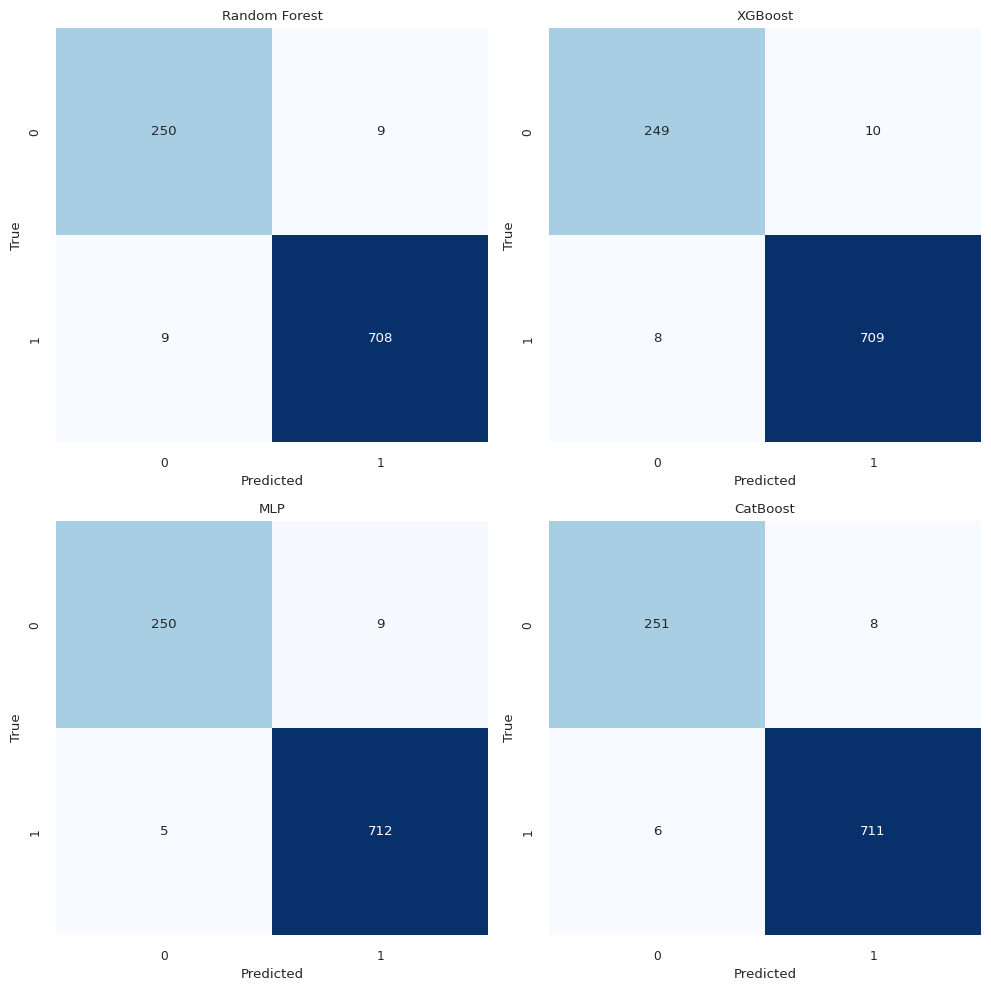

In [6]:
# ----------------------------------------- Create DataFrame to store results-----------------------------------------
MODELS = {
    "Random Forest": RandomForestClassifier(random_state=SEED),
    "XGBoost": XGBClassifier(random_state=SEED),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(128, 128, 64, 32),
        activation="logistic",
        solver="adam",
        random_state=SEED,
    ),
    "CatBoost": CatBoostClassifier(random_state=SEED, verbose=0),
}

METRICS = {
    "Test Acc": accuracy_score,
    "Macro F1": f1_score,
    "Balanced Accuracy": balanced_accuracy_score,
}

result_df = pd.DataFrame(columns=list(METRICS.keys()), index=list(MODELS.keys()))
cm_dict = {}

# ----------------------------------------- Loop over each feature-----------------------------------------
for model_name, clf in MODELS.items():
    print(f"\nTraining {model_name}")

    # fit the model
    clf.fit(X_train, y_train_newlabel)

    for metric, funct in METRICS.items():
        print(f"\tCalculating {metric}")
        y_pred = clf.predict(X_test)

        if "Macro" in metric:
            result_df.loc[model_name, metric] = funct(
                y_test_newlabel, y_pred, average="macro"
            )
        else:
            result_df.loc[model_name, metric] = funct(y_test_newlabel, y_pred)
        # cf
        cf = confusion_matrix(y_test_newlabel, y_pred)
        cm_dict[model_name] = cf

# ----------------------------------------- Save the results-----------------------------------------
result_df.to_csv(MODELS_RESULTS + RESULT_NAME)
np.save(MODELS_RESULTS + CM_ARTIFACT_NAME, cm_dict)

# show the confusion matrix
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, (model_name, cf) in enumerate(cm_dict.items()):
    sns.heatmap(cf, annot=True, fmt="d", ax=ax[i // 2, i % 2], cmap="Blues", cbar=False)
    ax[i // 2, i % 2].set_title(model_name)
    ax[i // 2, i % 2].set_xlabel("Predicted")
    ax[i // 2, i % 2].set_ylabel("True")
plt.tight_layout()
result_df

In [7]:
best_artifact_model = CatBoostClassifier(random_state=SEED, verbose=0)
best_artifact_model.fit(X_train, y_train_newlabel)

## 2nd model - Normal or not


| Name        | Label |
| ----------- | ----- |
| artifacts   | 0     |
| extrahls    | 1     |
| murmurs     | 2     |
| normals     | 3     |
| extrastoles | 4     |

In [8]:
# prepare the data
old_to_new_labels = {1: 1, 2: 1, 3: 0, 4: 1}

# get the data
X_train = full_data["train"]["X"]
X_test = full_data["test"]["X"]
y_train = full_data["train"]["y"]
y_test = full_data["test"]["y"]

# remove artifacts
train_mask = np.isin(y_train, [1, 2, 3, 4])
test_mask = np.isin(y_test, [1, 2, 3, 4])

X_train_normal = X_train[train_mask]
X_test_normal = X_test[test_mask]
y_train_normal = np.vectorize(old_to_new_labels.get)(y_train[train_mask])
y_test_normal = np.vectorize(old_to_new_labels.get)(y_test[test_mask])


# Count the number of samples per class
unique, counts = np.unique(y_train_normal, return_counts=True)
print("Train class distribution")
print(dict(zip(unique, counts)))

train = np.concatenate((X_train_normal, y_train_normal.reshape(-1, 1)), axis=1)
train = np.concatenate((train, y_train_normal.reshape(-1, 1)), axis=1)

target_size = int((counts.max() + counts.min()) / 2)

print(f"Target size: {target_size}")
train_balanced = rebalance_data(train, target_size=target_size, random_seed=42)

X_train_normal = train_balanced[:, :-2]
y_train_normal = train_balanced[:, -2]

unique, counts = np.unique(y_train_normal, return_counts=True)
print("Train class distribution after balancing")
print(dict(zip(unique, counts)))

Train class distribution
{0: 1760, 1: 1204}
Target size: 1482
Train class distribution after balancing
{0.0: 1482, 1.0: 1482}



Training Random Forest
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training XGBoost
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training MLP
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training CatBoost
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy


,Test Acc,Macro F1,Balanced Accuracy
Random Forest,0.7894,0.778936,0.774492
XGBoost,0.801953,0.797267,0.795105
MLP,0.796374,0.793741,0.794142
CatBoost,0.818689,0.812624,0.808726


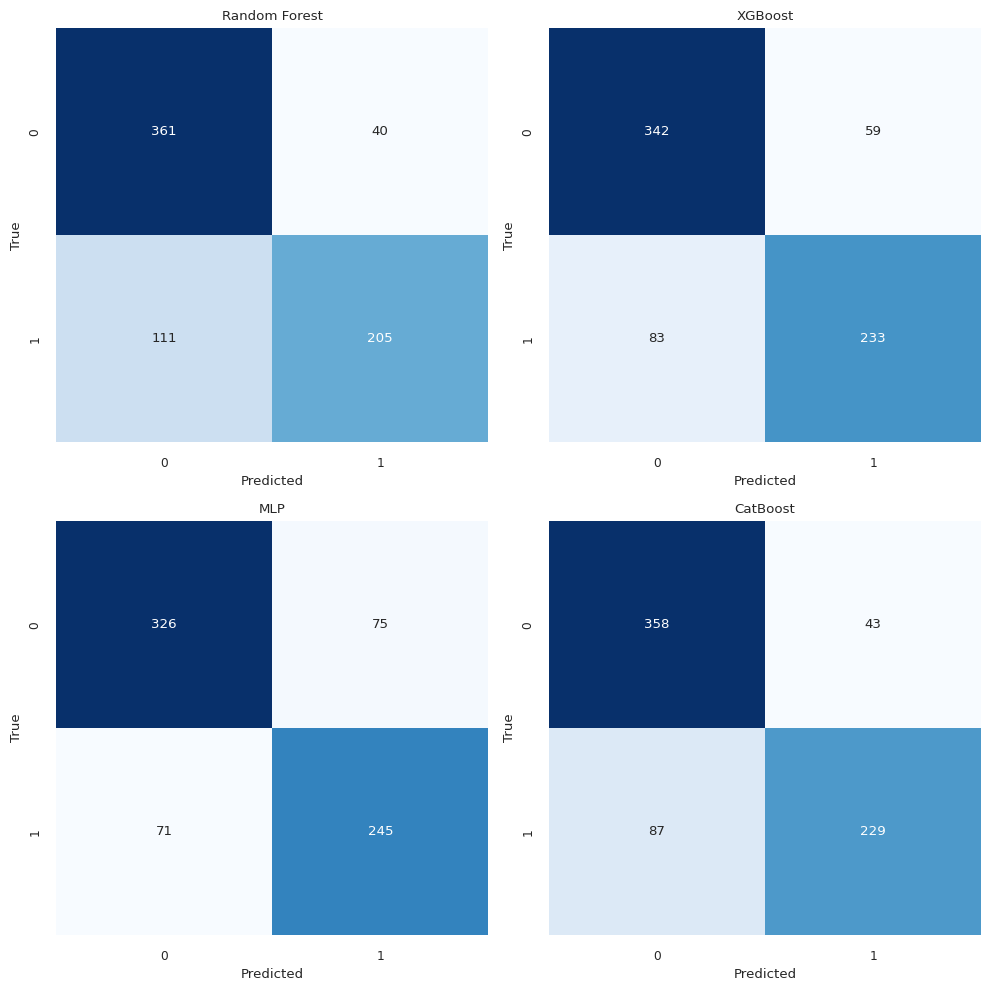

In [9]:
# df to store the results
result_df = pd.DataFrame(columns=list(METRICS.keys()), index=list(MODELS.keys()))
cm_dict = {}

# ----------------------------------------- Loop over each feature-----------------------------------------
for model_name, clf in MODELS.items():
    print(f"\nTraining {model_name}")

    # fit the model
    clf.fit(X_train_normal, y_train_normal)

    for metric, funct in METRICS.items():
        print(f"\tCalculating {metric}")
        y_pred = clf.predict(X_test_normal)

        if "Macro" in metric:
            result_df.loc[model_name, metric] = funct(y_test_normal, y_pred, average="macro")
        else:
            result_df.loc[model_name, metric] = funct(y_test_normal, y_pred)
        # cf
        cf = confusion_matrix(y_test_normal, y_pred)
        cm_dict[model_name] = cf

# ----------------------------------------- Save the results-----------------------------------------
result_df.to_csv(MODELS_RESULTS + RESULT_NAME)
np.save(MODELS_RESULTS + CM_DISEASE_NAME, cm_dict)

# show the confusion matrix
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, (model_name, cf) in enumerate(cm_dict.items()):
    sns.heatmap(cf, annot=True, fmt='d', ax=ax[i//2, i%2], cmap='Blues', cbar=False)
    ax[i//2, i%2].set_title(model_name)
    ax[i//2, i%2].set_xlabel('Predicted')
    ax[i//2, i%2].set_ylabel('True')
plt.tight_layout()

result_df

In [10]:
best_normal_model = CatBoostClassifier(random_state=SEED, verbose=0)
best_normal_model.fit(X_train_normal, y_train_normal)

## 3rd model  diseases


| Name        | Label |
| ----------- | ----- |
| artifacts   | 0     |
| extrahls    | 1     |
| murmurs     | 2     |
| normals     | 3     |
| extrastoles | 4     |

In [11]:
# prepare the data
old_to_new_labels = {1: 0, 2: 1, 4: 2}

# get the data
X_train = full_data["train"]["X"]
X_test = full_data["test"]["X"]
y_train = full_data["train"]["y"]
y_test = full_data["test"]["y"]

# remove artifacts and normal
train_mask = np.isin(y_train, [1, 2, 4])
test_mask = np.isin(y_test, [1, 2, 4])

X_train_diseases = X_train[train_mask]
X_test_diseases = X_test[test_mask]
y_train_diseases = np.vectorize(old_to_new_labels.get)(y_train[train_mask])
y_test_diseases = np.vectorize(old_to_new_labels.get)(y_test[test_mask])


# Count the number of samples per class
unique, counts = np.unique(y_train_diseases, return_counts=True)
print("Train class distribution")
print(dict(zip(unique, counts)))

train = np.concatenate((X_train_diseases, y_train_diseases.reshape(-1, 1)), axis=1)
train = np.concatenate((train, y_train_diseases.reshape(-1, 1)), axis=1)

target_size = int((counts.max() + counts.min()) / 2)

print(f"Target size: {target_size}")
train_balanced = rebalance_data(train, target_size=target_size, random_seed=42)

X_train_diseases = train_balanced[:, :-2]
y_train_diseases = train_balanced[:, -2]

unique, counts = np.unique(y_train_diseases, return_counts=True)
print("Train class distribution after balancing")
print(dict(zip(unique, counts)))

Train class distribution
{0: 106, 1: 905, 2: 193}
Target size: 505
Train class distribution after balancing
{0.0: 505, 1.0: 505, 2.0: 505}



Training Random Forest
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training XGBoost
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training MLP
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training CatBoost
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy


,Test Acc,Macro F1,Balanced Accuracy
Random Forest,0.844937,0.790271,0.817699
XGBoost,0.873418,0.83357,0.860909
MLP,0.892405,0.863614,0.905485
CatBoost,0.879747,0.837357,0.87118


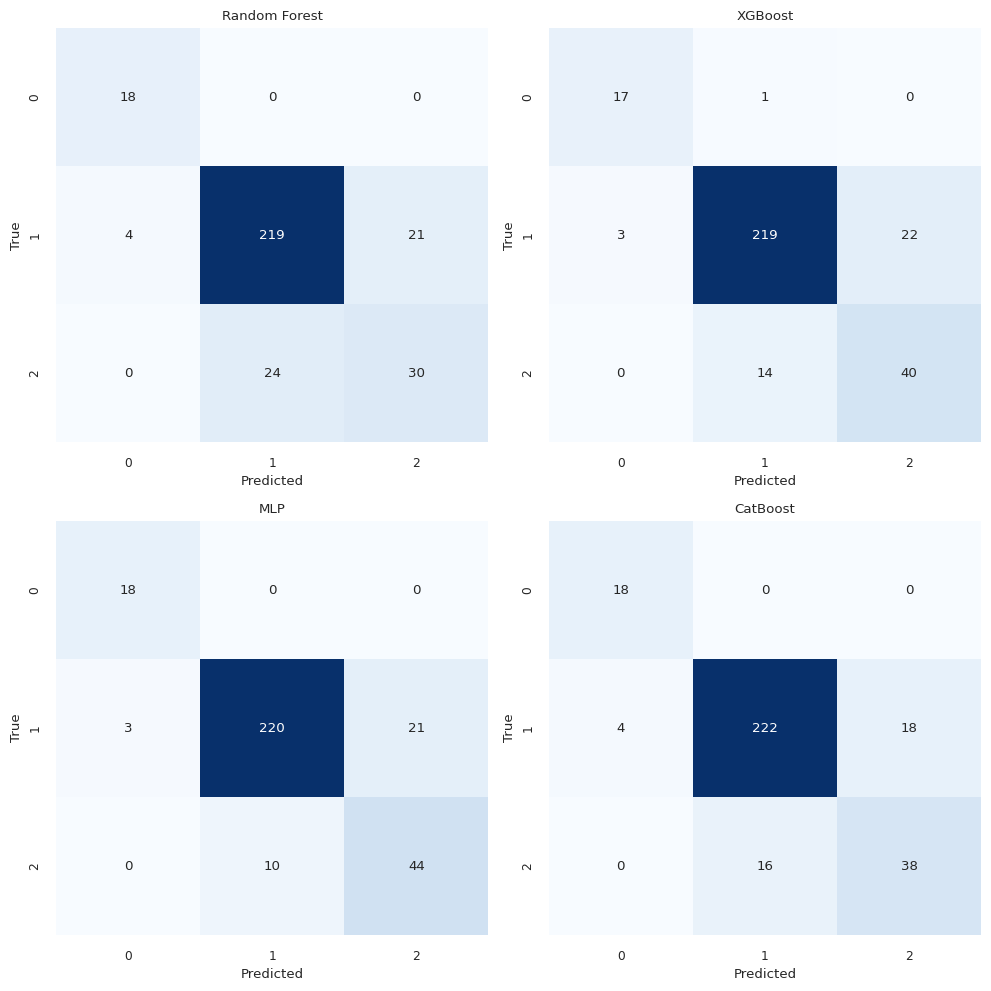

In [12]:
# df to store the results
result_df = pd.DataFrame(columns=list(METRICS.keys()), index=list(MODELS.keys()))
cm_dict = {}

# ----------------------------------------- Loop over each feature-----------------------------------------
for model_name, clf in MODELS.items():
    print(f"\nTraining {model_name}")

    # fit the model
    clf.fit(X_train_diseases, y_train_diseases)

    for metric, funct in METRICS.items():
        print(f"\tCalculating {metric}")
        y_pred = clf.predict(X_test_diseases)

        if "Macro" in metric:
            result_df.loc[model_name, metric] = funct(y_test_diseases, y_pred, average="macro")
        else:
            result_df.loc[model_name, metric] = funct(y_test_diseases, y_pred)
        # cf
        cf = confusion_matrix(y_test_diseases, y_pred)
        cm_dict[model_name] = cf

# ----------------------------------------- Save the results-----------------------------------------
result_df.to_csv(MODELS_RESULTS + RESULT_NAME)
np.save(MODELS_RESULTS + CM_DISEASE_NAME, cm_dict)

# show the confusion matrix
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, (model_name, cf) in enumerate(cm_dict.items()):
    sns.heatmap(cf, annot=True, fmt='d', ax=ax[i//2, i%2], cmap='Blues', cbar=False)
    ax[i//2, i%2].set_title(model_name)
    ax[i//2, i%2].set_xlabel('Predicted')
    ax[i//2, i%2].set_ylabel('True')
plt.tight_layout()

result_df

In [13]:
best_disease_model = CatBoostClassifier(random_state=SEED, verbose=0)
best_disease_model.fit(X_train_normal, y_train_normal)


| Name        | Label |
| ----------- | ----- |
| artifacts   | 0     |
| extrahls    | 1     |
| murmurs     | 2     |
| normals     | 3     |
| extrastoles | 4     |

## Uso un quarto modello per predire

In [14]:
# Extract data from the dictionary
full_data = np.load(FEATURES_RAW + FILENAME_RAW, allow_pickle=True).item()
n_cols = full_data["train"]["X"].shape[1]

# Extract data from the dictionary
X_train = full_data["train"]["X"]
y_train = full_data["train"]["y"]
X_test = full_data["test"]["X"]
y_test = full_data["test"]["y"]



Training Random Forest
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training XGBoost
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training MLP
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training CatBoost
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy


,Test Acc,Macro F1,Balanced Accuracy
Random Forest,0.810451,0.505358,0.522519
XGBoost,0.810451,0.505358,0.522519
MLP,0.810451,0.505358,0.522519
CatBoost,0.810451,0.505358,0.522519


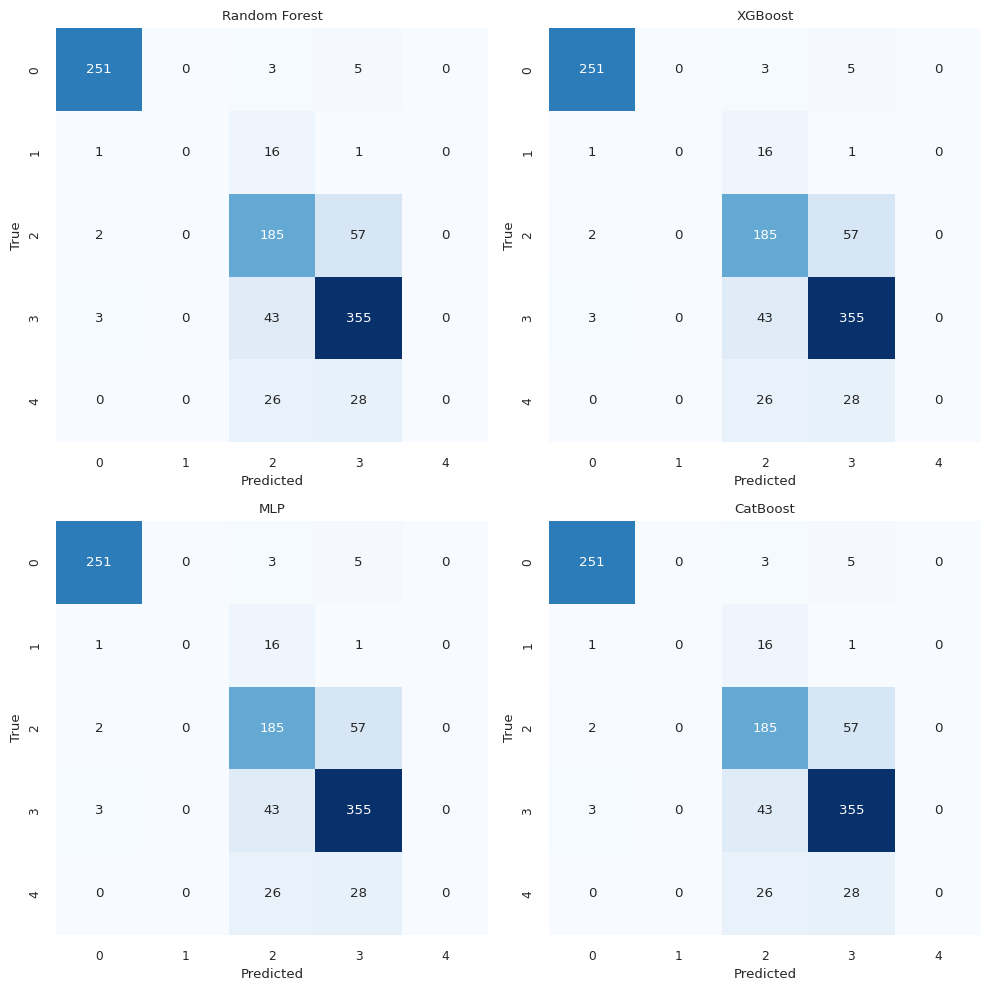

In [15]:
# Predictions for training data
pred_artifact_train = best_artifact_model.predict(X_train)
pred_normal_train = best_normal_model.predict(X_train)
pred_disease_train = best_disease_model.predict(X_train)

pred_artifact_test = best_artifact_model.predict(X_test)
pred_normal_test = best_normal_model.predict(X_test)
pred_disease_test = best_disease_model.predict(X_test)

# Concatenate predictions to form new feature set
X_train_new = np.concatenate(
    (
        pred_artifact_train.reshape(-1, 1),
        pred_disease_train.reshape(-1, 1),
        pred_disease_train.reshape(-1, 1),
    ),
    axis=1,
)

X_test_new = np.concatenate(
    (
        pred_artifact_test.reshape(-1, 1),
        pred_disease_test.reshape(-1, 1),
        pred_disease_test.reshape(-1, 1),
    ),
    axis=1,
)

for model_name, clf in MODELS.items():
    print(f"\nTraining {model_name}")

    # fit the model
    clf.fit(X_train_new, y_train)

    for metric, funct in METRICS.items():
        print(f"\tCalculating {metric}")
        y_pred = clf.predict(X_test_new)

        if "Macro" in metric:
            result_df.loc[model_name, metric] = funct(
                y_test, y_pred, average="macro"
            )
        else:
            result_df.loc[model_name, metric] = funct(y_test, y_pred)
        # cf
        cf = confusion_matrix(y_test, y_pred)
        cm_dict[model_name] = cf

# ----------------------------------------- Save the results-----------------------------------------
result_df.to_csv(MODELS_RESULTS + RESULT_NAME)
np.save(MODELS_RESULTS + CM_DISEASE_NAME, cm_dict)

# show the confusion matrix
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, (model_name, cf) in enumerate(cm_dict.items()):
    sns.heatmap(cf, annot=True, fmt="d", ax=ax[i // 2, i % 2], cmap="Blues", cbar=False)
    ax[i // 2, i % 2].set_title(model_name)
    ax[i // 2, i % 2].set_xlabel("Predicted")
    ax[i // 2, i % 2].set_ylabel("True")
plt.tight_layout()

result_df